In [1]:
from pathlib import Path
import sys

parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
#from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob
import torch.nn.functional as F
import warnings
from sklearn.metrics import mean_squared_error
#import mae function
from sklearn.metrics import mean_absolute_error
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

In [4]:
# dataread and features
from data.preprocess import read_txn_data , preprocess_txn_data, compute_lob_features, \
    create_lob_dataset, merge_txn_and_lob

# desesonalisation
from models.deseasonalization import deses

# Parameters

In [5]:
def set_neurips_style():
    plt.rcParams.update({
        "font.family":       "sans-serif",
        "font.size":         12,
        "axes.spines.top":   False,
        "axes.spines.right": False,
        "axes.grid":         True,
        "grid.linestyle":    ":",
        "grid.alpha":        0.5,
        "figure.dpi":        120,
        "legend.frameon":    False,
    })

set_neurips_style()

In [6]:
config = {
    "data_split": {
        "train_size": 0.7,
        "validation_size": 0.1,
        "test_size": 0.2
    },
    "model_params": {
        "learning_rate": 0.001,
        "batch_size": 10000,
        "epochs": 5,
    }
}

# Check GPU 

In [7]:
import torch

if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
    print(f"Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Reserved : {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
    print(f"Max Alloc: {torch.cuda.max_memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Max Rsvd : {torch.cuda.max_memory_reserved(0) / 1024**2:.2f} MB")
else:
    print("CUDA not available.")


Device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Allocated: 0.00 MB
Reserved : 0.00 MB
Max Alloc: 0.00 MB
Max Rsvd : 0.00 MB


In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1 Min 

#### 1.1 Load Data

In [9]:
freq='5min'
trx_df = read_txn_data(use_load=False)
lob_df = create_lob_dataset(use_load=False)
trx_df = preprocess_txn_data(trx_df,freq, fill_missing_ts=False)
df_raw = merge_txn_and_lob(trx_df, lob_df)
df_des, _ = deses(df_raw, train_size=config["data_split"]["train_size"])

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


#### 1.2 TME ENSAMBLE

ep01  train 2.4153  val 2.7033
ep02  train 2.1001  val 2.3845
ep03  train 1.9733  val 2.2240
ep04  train 1.9212  val 2.1558
ep05  train 1.9354  val 2.1267
RMSE 36.06502949381126 MAE 19.160077003220053 R2 -0.042804093953780153 MAPE% 497.3129420683926 Coverage 99.72294654498045


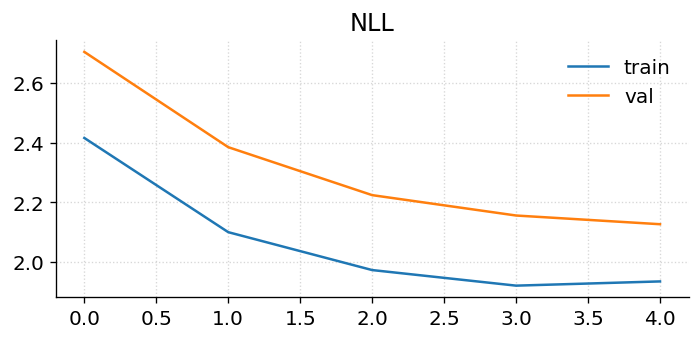

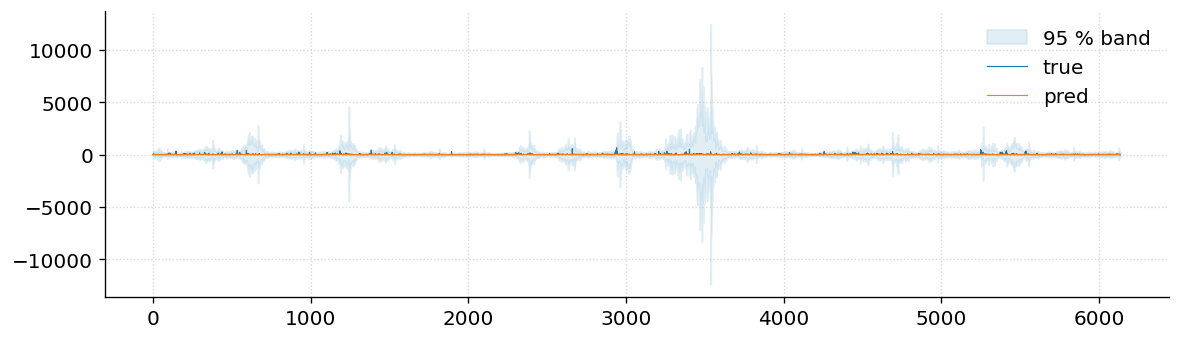

In [10]:
from models.tme import TME
tme = TME(df_des, config)   # config is the dict you already have
tme.train()                 # prints epoch-wise NLL
tme.evaluate()              # metrics + two plots

# 5 Min

# 10 Min